## Курсовой проект
#### По дисциплине "Методы, средства и технологии мультимедиа"
Выполнил Гаврилов М.С.  
Группа М8О-406Б-19

In [2]:
import pylab
import numpy as np
import copy

import sklearn as skl
from sklearn import datasets
from sklearn.pipeline import Pipeline
from nerus import load_nerus

import random

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from matplotlib import gridspec

### Датасет

In [3]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

### Постановка задачи 
Методами машинного обучения поздать модель, способную определять часть речи слова русского языка. Для обучения и тестирования используется датасет nerus, алгоритм - случайный лес.

### Анализ датасета и определение признаков
Датасет представляет из себя набор токенизированных предложений. Для решаемой задачи потребуется только слово (в виде текста) и его класс (часть речи). Извечем их.

Определим, какие классы присутствуют в датасете

In [4]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

PossibleClasses = []
selLen = 5000 #ограничитель, чтобы проходить не весь датасет, а только часть

for i in range (selLen):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
                         
            if(not token.pos in PossibleClasses):
                PossibleClasses.append(token.pos)

print(PossibleClasses)

['NOUN', 'ADP', 'ADJ', 'PROPN', 'VERB', 'PUNCT', 'DET', 'ADV', 'PRON', 'CCONJ', 'SCONJ', 'NUM', 'PART', 'AUX', 'X', 'SYM', 'INTJ']


In [5]:
Classes = PossibleClasses

Вероятно, не все классы подлежат помещению в выборку. Определим, что из себя представляют представлители классов.

['NOUN', 'ADP', 'ADJ', 'PROPN', 'VERB', 'PUNCT', 'DET', 'ADV', 'PRON', 'CCONJ', 'SCONJ', 'NUM', 'PART', 'AUX', 'X', 'SYM', 'INTJ']

In [6]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

selLen = 5000 #ограничитель, чтобы проходить не весь датасет, а только часть
ClCnt = np.zeros(len(Classes))
ClExmp = [[] for i in range(len(Classes))]


for i in range (selLen):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
                         
            if(ClCnt[PossibleClasses.index(token.pos)] < 5):
                ClCnt[PossibleClasses.index(token.pos)] += 1
                ClExmp[PossibleClasses.index(token.pos)].append(token.text)


In [7]:
for i in range(len(ClExmp)):
    print(PossibleClasses[i])
    for exmpl in ClExmp[i]:
        print("\t{}".format(exmpl))

NOUN
	Вице-премьер
	вопросам
	регионах
	смертность
	рака
ADP
	по
	в
	от
	По
	в
ADJ
	социальным
	высокая
	онкологические
	Псковской
	Тверской
PROPN
	Татьяна
	Голикова
	России
	РИА
	Новости
VERB
	рассказала
	зафиксирована
	сообщает
	становились
	напомнила
PUNCT
	,
	,
	.
	,
	,
DET
	каких
	Каких-либо
	Все
	Таким
	всем
ADV
	наиболее
	чаще
	также
	впервые
	ранее
PRON
	всего
	Это
	этом
	они
	их
CCONJ
	и
	а
	и
	а
	и
SCONJ
	что
	что
	чем
	Как
	как
NUM
	три
	289
	3,5
	меньше
	три
PART
	не
	не
	именно
	ли
	только
AUX
	будет
	были
	было
	была
	был
X
	#
	metoo
	#
	timesup
	marchforourlives
SYM
	+
	+
	&
	+
	№
INTJ
	Фу
	О
	О
	ура
	ура


Подсчитаем частотность классов в датасете

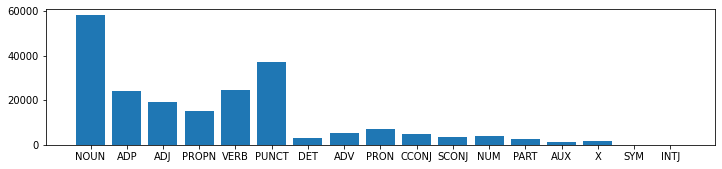

In [8]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClCnt = np.zeros(len(PossibleClasses))

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in PossibleClasses):
                clN = PossibleClasses.index(token.pos)
                ClCnt[clN] += 1

fig, ax = pylab.subplots()
fig.set_figwidth(12)
fig.set_figheight(2.5) 

ax.bar(PossibleClasses,ClCnt)
pylab.xticks(np.arange(len(PossibleClasses)))
pylab.show()

Определяем классы, которые можно использовать для решения задачи (все, кроме пунктуации, математических действий и 'X'), а также классы, от слов которых можно требовать уникальности (такие, к которым относятся 1000+ различных слов русского языка)

In [9]:
Classes   = ['NOUN', 'ADP', 'ADJ', 'PROPN', 'VERB', 'DET', 'ADV', 
             'PRON', 'CCONJ', 'SCONJ', 'NUM', 'PART', 'AUX']
ClassesUQ = ['NOUN', 'ADJ', 'PROPN', 'VERB', 'ADV', 'NUM'] 
            #исключаются те классы, для которых из 5000 предложений не найдено 500 уникальных примеров

Генерируем сбаллансированную выборку (так как в датасете столь много слов, что берется лишь часть)

Выборка с уникальными словами позволит исследовать справедливось предположения о деградации модели в словарь

In [10]:
def create_dataset(selLen = 5000,ClLen = 500,AllowedClasses = Classes,unique = False):
                   #сколько предложений просмотреть
                                 #сколько слов должно быть в каждом классе
                                            #какие части речи добавлять
                                                                      #требуется ли уникальность слов в датасете
        
    ClCnt = np.zeros(len(AllowedClasses))

    larrLB = [] #классы слов
    larrDC = [] #слова
    
    docs = load_nerus('nerus/nerus_lenta.conllu.gz') #заново загружаем датасет

    #Формирование обучающего датасета
    for i in range (selLen):
        doc = next(docs) #идем по предложениям
        
        for sent in doc.sents:
            for token in sent.tokens:
                if(token.pos in AllowedClasses):
                        clN = AllowedClasses.index(token.pos)

                        if(ClCnt[clN] < ClLen):
                            
                            if(unique and token.text in larrDC):
                                continue                                

                            ClCnt[clN] += 1

                            larrLB.append(AllowedClasses.index(token.pos))
                            larrDC.append(token.text)



    ClCnt = np.zeros(len(AllowedClasses))

    tarrLB = []
    tarrDC = []

    #формирование тестового датасета
    for i in range (selLen):
        doc = next(docs)
        
        for sent in doc.sents:
            for token in sent.tokens:
                if(token.pos in AllowedClasses):
                        clN = AllowedClasses.index(token.pos)

                        if(ClCnt[clN] < ClLen):
                            
                            if(unique and (token.text in tarrDC or token.text in larrDC)):
                                continue                    

                            ClCnt[clN] += 1

                            tarrLB.append(AllowedClasses.index(token.pos))
                            tarrDC.append(token.text)

    return np.array(larrLB),np.array(larrDC),np.array(tarrLB),np.array(tarrDC)

In [11]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset(selLen = 10000)

with unique = false
words in train selection:
6500
unique words in train selection:
2191
count of words in dataset per class:


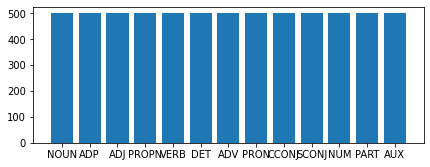

In [12]:
print("with unique = false")
print("words in train selection:")
print(len(larrDC))
print("unique words in train selection:")
print(len(np.unique(larrDC)))

print("count of words in dataset per class:")
fig, ax = pylab.subplots()
fig.set_figwidth(7)
fig.set_figheight(2.5) 

ax.bar(Classes,np.unique(larrLB,return_counts = True)[1])
pylab.xticks(np.arange(len(Classes)))
pylab.show()

In [13]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset(AllowedClasses = ClassesUQ,unique = True)

with unique = false
words in train selection:
3000
unique words in train selection:
3000
count of words in dataset per class:


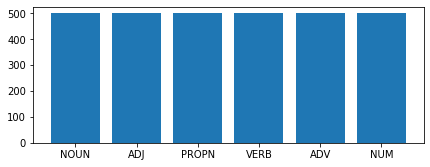

In [14]:
print("with unique = false")
print("words in train selection:")
print(len(larrDC))
print("unique words in train selection:")
print(len(np.unique(larrDC)))

print("count of words in dataset per class:")
fig, ax = pylab.subplots()
fig.set_figwidth(7)
fig.set_figheight(2.5) 

ax.bar(ClassesUQ,np.unique(larrLB,return_counts = True)[1])
pylab.xticks(np.arange(len(ClassesUQ)))
pylab.show()

## Определение оптимальных признаков.

Предполагаемые признаки:  
- первая буква слова
- последняя буква слова
- предпоследняя буква слова
- длина слова 

Убедимся, что слова разных классов различаются по этим признакам    
Также проверим вторую букву слова и третью с конца букву, возможно, они понадобятся для улучшения точности

In [15]:
alphabet = ['а', 'е', 'ё', 'и', 'о', 'у', 'ы', 'э', 'ю', 'я', 
            'б', 'в', 'г', 'д', 'ж', 'з', 'й', 'к', 'л', 'м', 'н', 'п', 'р', 'с', 'т', 'ф', 'х', 'ц', 'ч', 'ш', 'щ',
            'ь', 'ъ']


FIRST letters by classes


NOUN


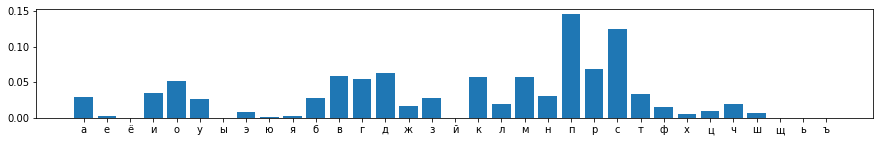

ADP


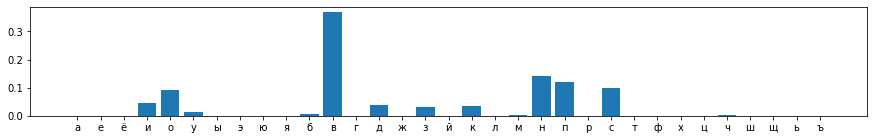

ADJ


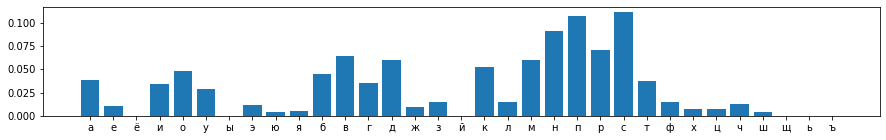

PROPN


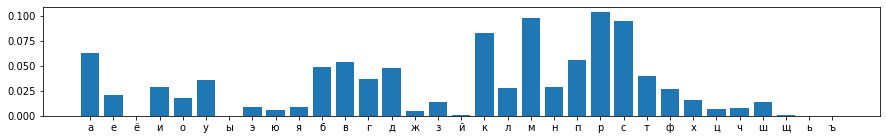

VERB


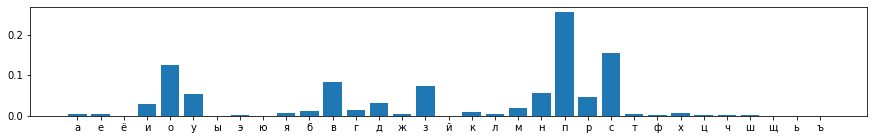

DET


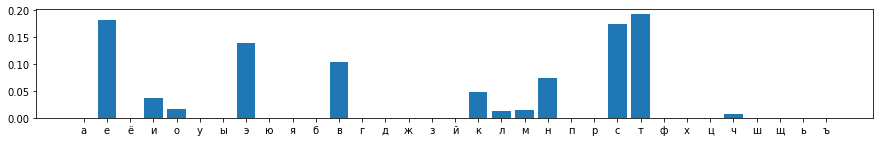

ADV


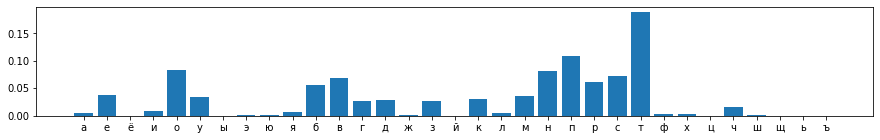

PRON


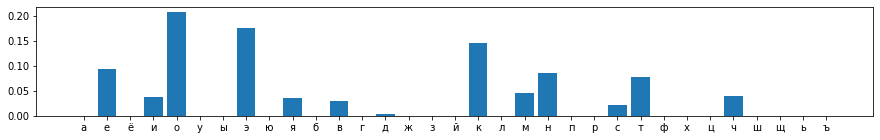

CCONJ


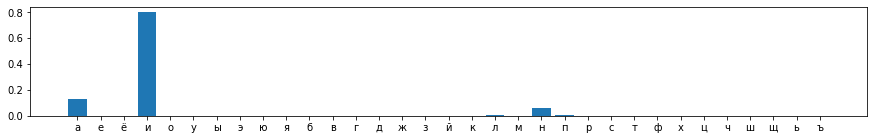

SCONJ


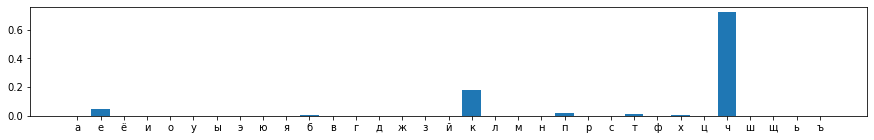

NUM


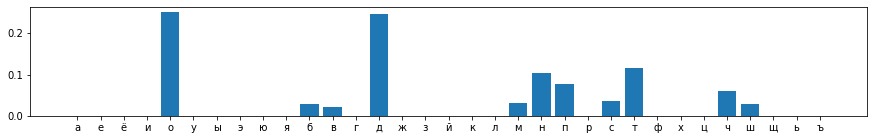

PART


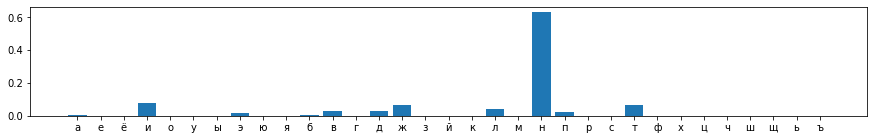

AUX


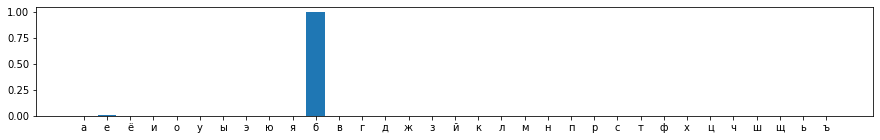

In [16]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClassFreqFST = np.zeros([len(Classes),len(alphabet)])
ClCnt = np.zeros(len(Classes)) #сколько слов каждого класса встретилось

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                
                try:
                    lp = alphabet.index(token.text.lower()[0])
                except(ValueError):
                    continue
                    
                clN = Classes.index(token.pos)
                                    
                ClassFreqFST[clN][lp] += 1
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqFST[i][j] /= ClCnt[i]


print("\nFIRST letters by classes\n\n")

for i in range(len(Classes)): 
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print((Classes[i]))
    ax.bar(alphabet,ClassFreqFST[i])
    pylab.xticks(np.arange(33))
    pylab.show()

Функция для вывода диаграмм для двух классов друг возле друга, чтобы их можно было легче сравнить:

In [17]:
def overlay(i,j, freq):
    try:
        s1 = int(i)
    except(BaseException):
        s1 = int(Classes.index(i))
    
    try:
        s2 = int(j)
    except(BaseException):
        s2 = int(Classes.index(j))
        
    
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(3) 
    
    a = np.arange(len(alphabet))
    
    ax.bar(a + 0.2,freq[s1],width = 0.4,label = Classes[s1])
    ax.bar(a - 0.2,freq[s2],width = 0.4,label = Classes[s2])
    
    ax.set_xticks(a)
    ax.set_xticklabels(alphabet)
    ax.legend()
    
    pylab.xticks(np.arange(33))
    pylab.show()

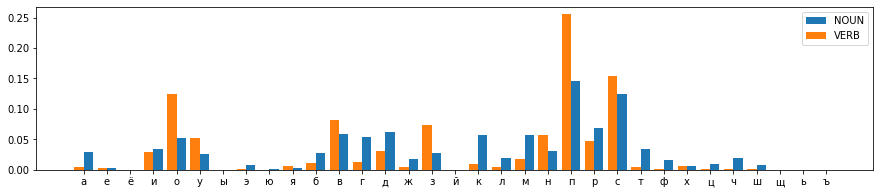

In [18]:
overlay("NOUN","VERB", ClassFreqFST)


LAST letters by classes


NOUN


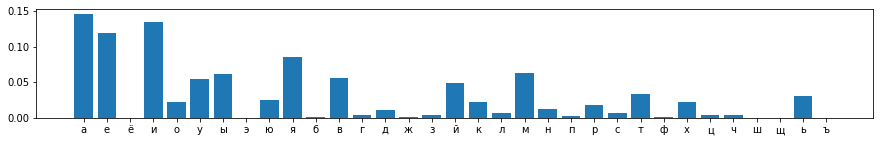

ADP


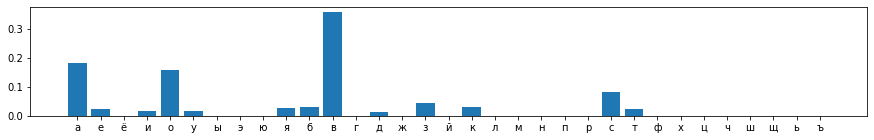

ADJ


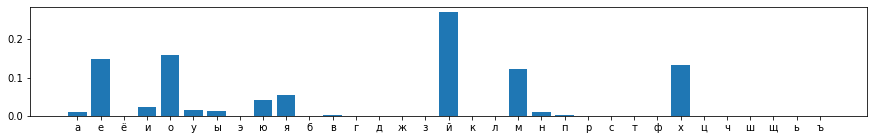

PROPN


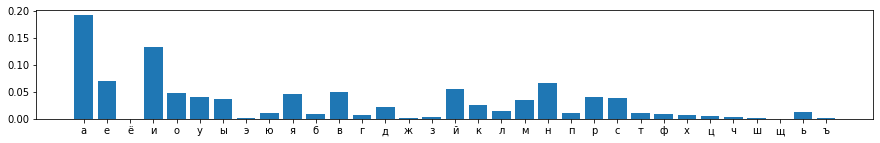

VERB


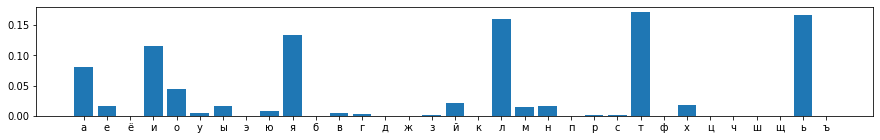

DET


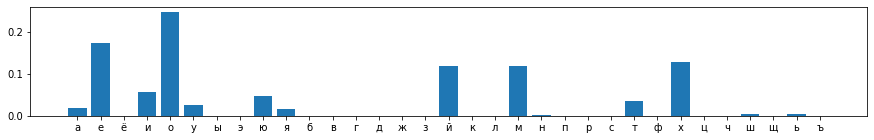

ADV


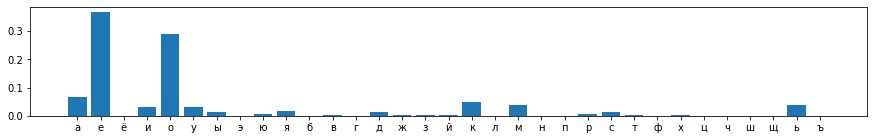

PRON


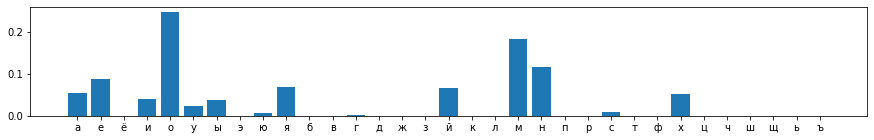

CCONJ


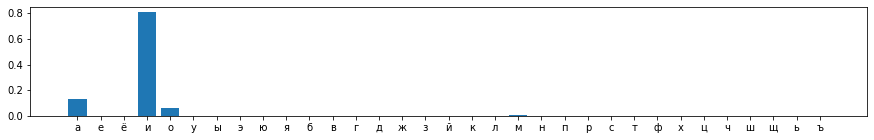

SCONJ


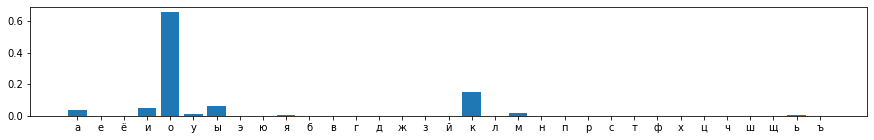

NUM


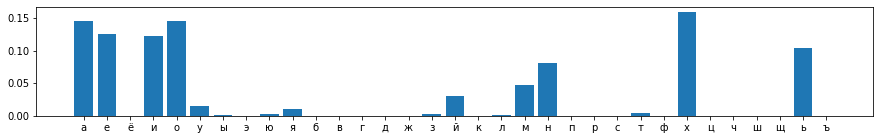

PART


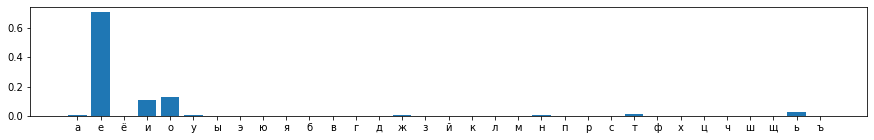

AUX


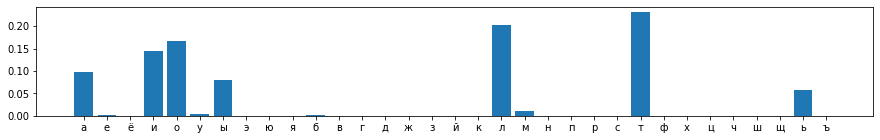

In [26]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClassFreqLST = np.zeros([len(Classes),len(alphabet)])
ClCnt = np.zeros(len(Classes)) #сколько слов каждого класса встретилось

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                
                try:
                    lp = alphabet.index(token.text.lower()[len(token.text) - 1])
                except(ValueError):
                    continue
                    
                clN = Classes.index(token.pos)
                                    
                ClassFreqLST[clN][lp] += 1
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqLST[i][j] /= ClCnt[i]


print("\nLAST letters by classes\n\n")

for i in range(len(Classes)): 
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print((Classes[i]))
    ax.bar(alphabet,ClassFreqLST[i])
    pylab.xticks(np.arange(33))
    pylab.show()

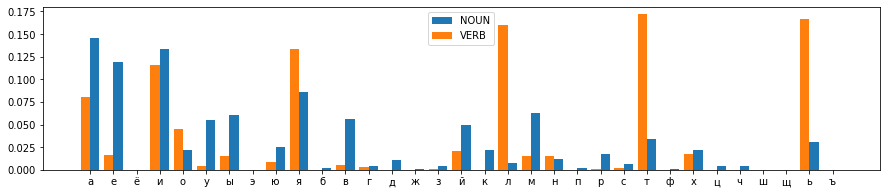

In [27]:
overlay("NOUN","VERB", ClassFreqLST)


2-d LAST letters by classes


NOUN


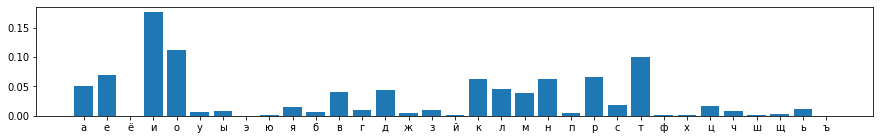

ADP


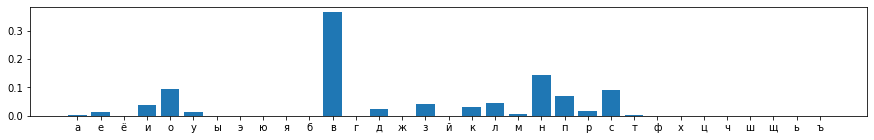

ADJ


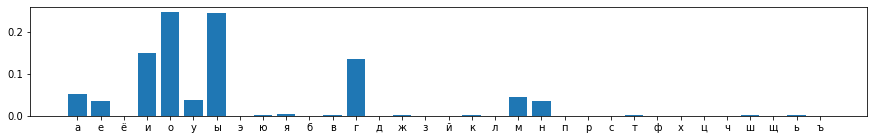

PROPN


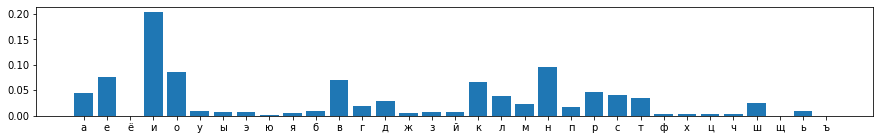

VERB


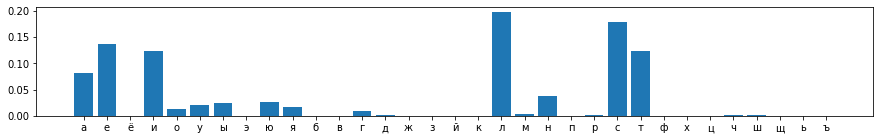

DET


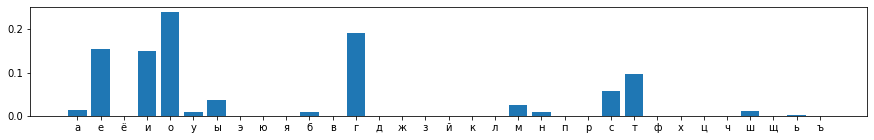

ADV


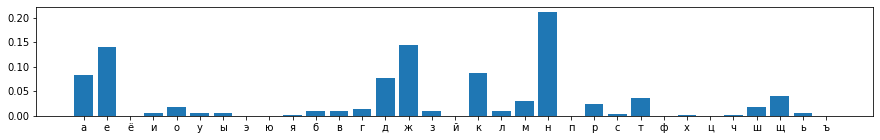

PRON


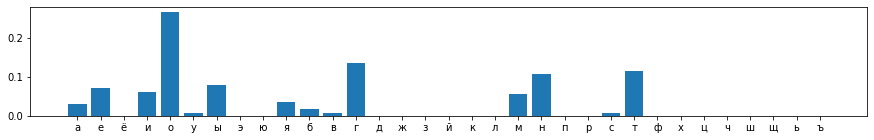

CCONJ


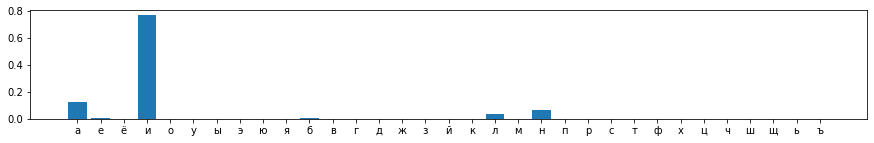

SCONJ


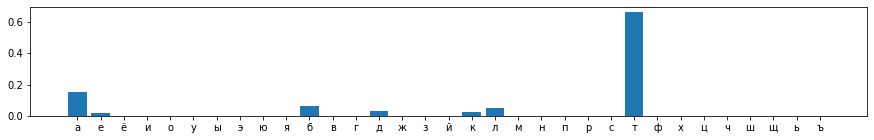

NUM


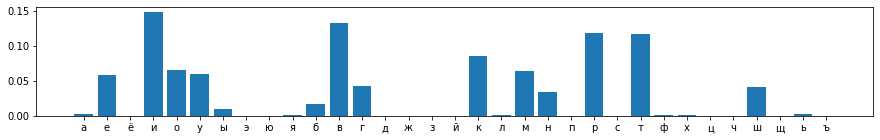

PART


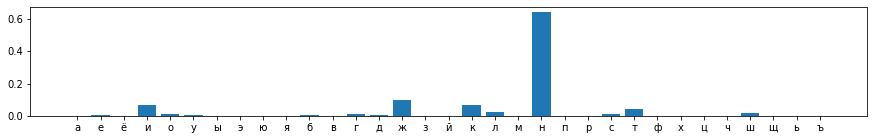

AUX


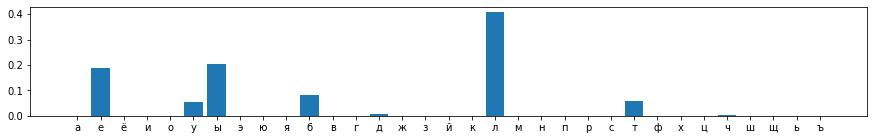

In [28]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClassFreqLST2 = np.zeros([len(Classes),len(alphabet)])
ClCnt = np.zeros(len(Classes)) #сколько слов каждого класса встретилось

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                
                try:
                    lp = alphabet.index(token.text.lower()[len(token.text) - 2])
                except(ValueError):
                    continue
                    
                clN = Classes.index(token.pos)
                                    
                ClassFreqLST2[clN][lp] += 1
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqLST2[i][j] /= ClCnt[i]


print("\n2-d LAST letters by classes\n\n")

for i in range(len(Classes)): 
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print((Classes[i]))
    ax.bar(alphabet,ClassFreqLST2[i])
    pylab.xticks(np.arange(33))
    pylab.show()

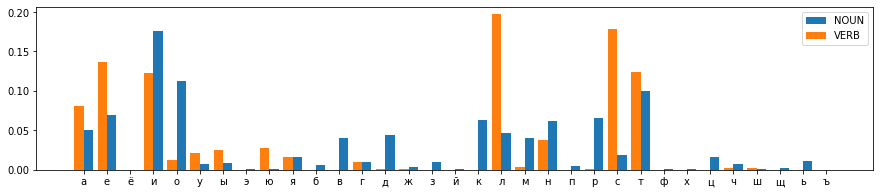

In [29]:
overlay("NOUN","VERB", ClassFreqLST2)

Третья с конца и вторая буквы


2-d FIRST letters by classes


NOUN


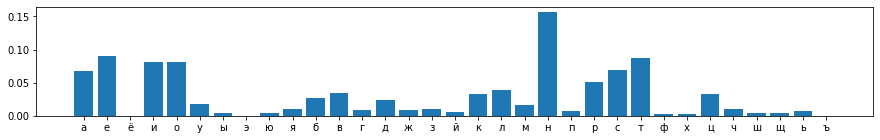

ADP


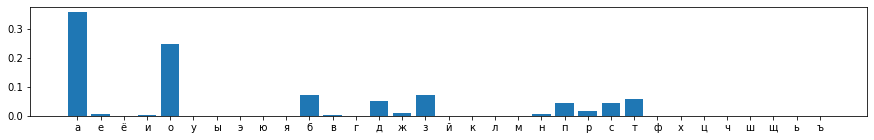

ADJ


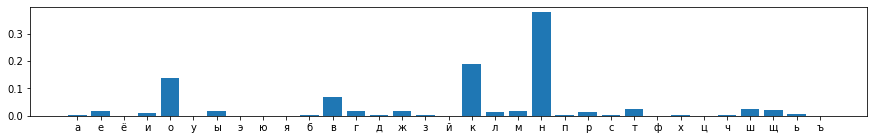

PROPN


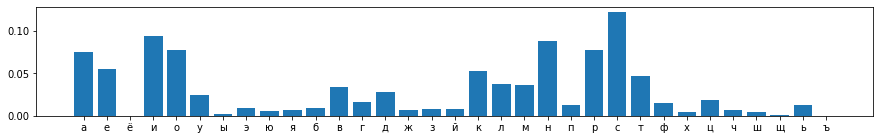

VERB


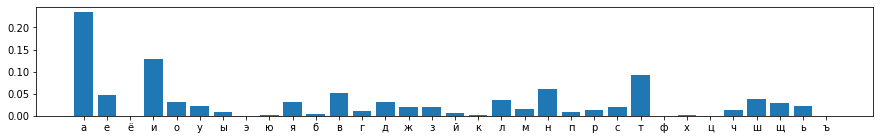

DET


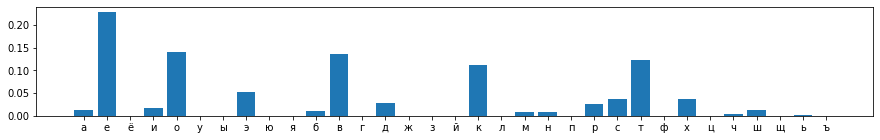

ADV


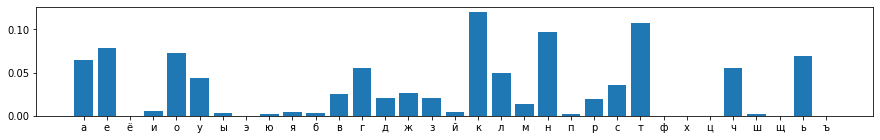

PRON


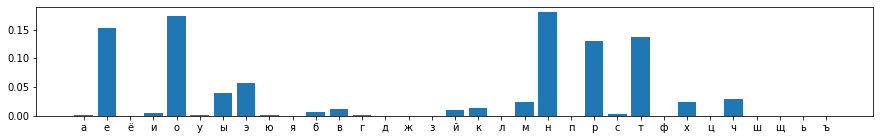

CCONJ


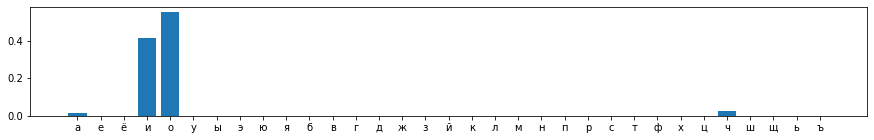

SCONJ


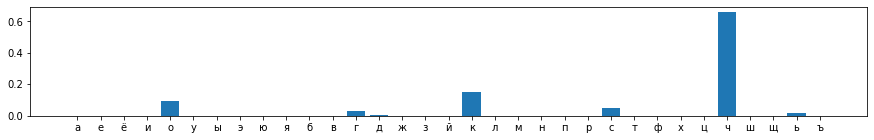

NUM


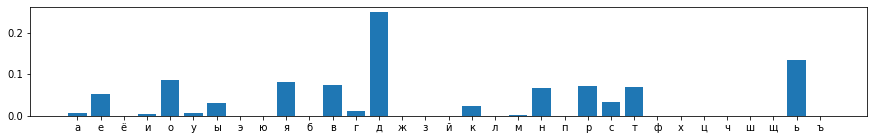

PART


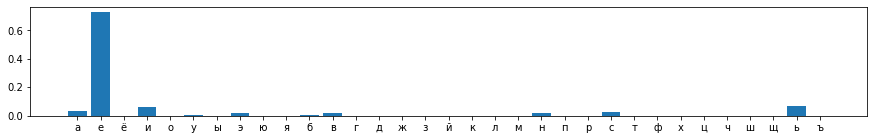

AUX


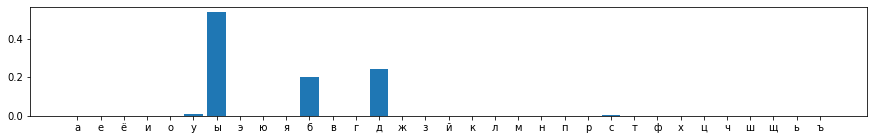

In [30]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClassFreqSCD = np.zeros([len(Classes),len(alphabet)])
ClCnt = np.zeros(len(Classes)) #сколько слов каждого класса встретилось

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                
                try:
                    lp = alphabet.index(token.text.lower()[len(token.text) - 3])
                except(ValueError):
                    continue
                except(IndexError):
                    continue
                    
                clN = Classes.index(token.pos)
                                    
                ClassFreqSCD[clN][lp] += 1
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqSCD[i][j] /= ClCnt[i]


print("\n2-d FIRST letters by classes\n\n")

for i in range(len(Classes)): 
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print((Classes[i]))
    ax.bar(alphabet,ClassFreqSCD[i])
    pylab.xticks(np.arange(33))
    pylab.show()

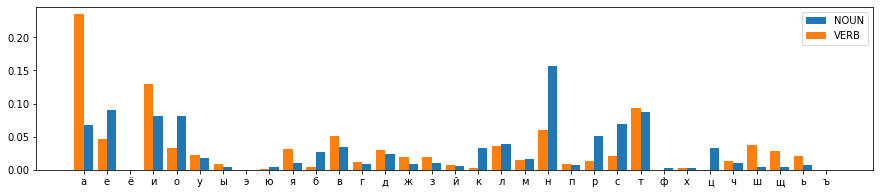

In [31]:
overlay("NOUN","VERB", ClassFreqSCD)


3-d LAST letters by classes


NOUN


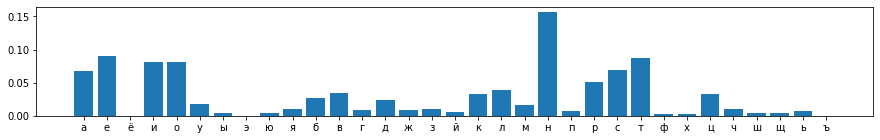

ADP


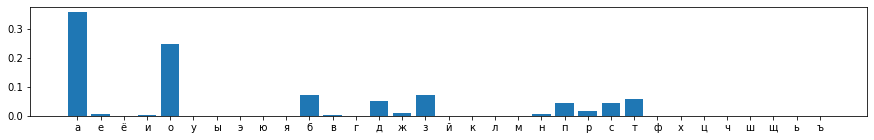

ADJ


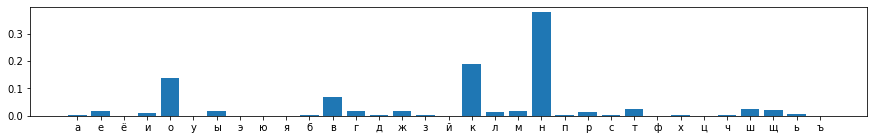

PROPN


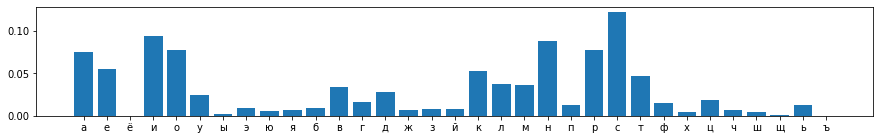

VERB


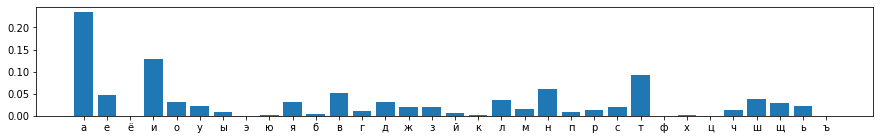

DET


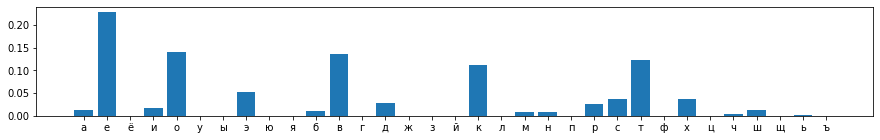

ADV


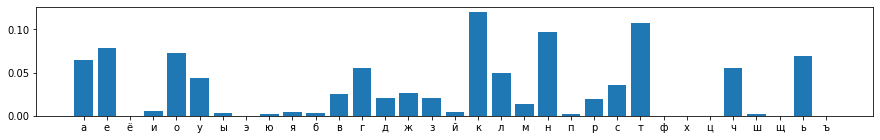

PRON


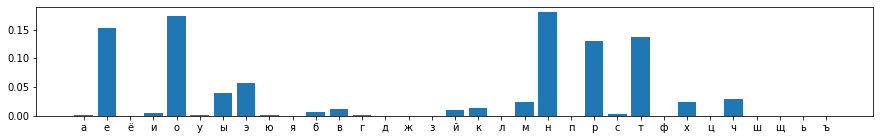

CCONJ


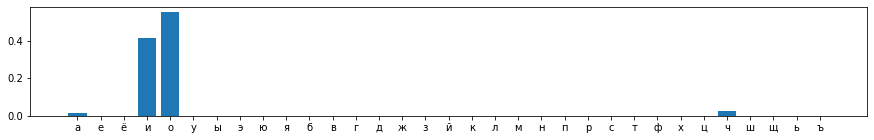

SCONJ


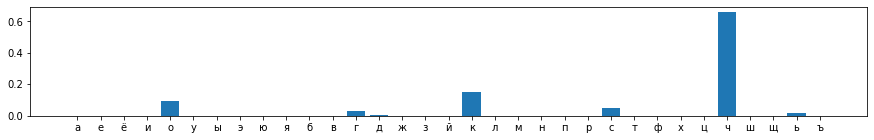

NUM


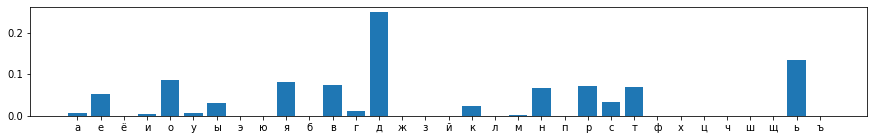

PART


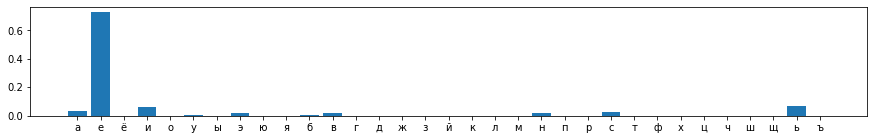

AUX


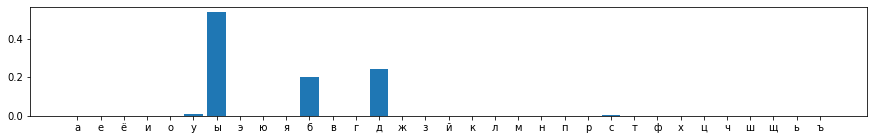

In [32]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClassFreqLST3 = np.zeros([len(Classes),len(alphabet)])
ClCnt = np.zeros(len(Classes)) #сколько слов каждого класса встретилось

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                
                try:
                    lp = alphabet.index(token.text.lower()[len(token.text) - 3])
                except(ValueError):
                    continue
                except(IndexError):
                    continue
                    
                clN = Classes.index(token.pos)
                                    
                ClassFreqLST3[clN][lp] += 1
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqLST3[i][j] /= ClCnt[i]


print("\n3-d LAST letters by classes\n\n")

for i in range(len(Classes)): 
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print((Classes[i]))
    ax.bar(alphabet,ClassFreqLST3[i])
    pylab.xticks(np.arange(33))
    pylab.show()

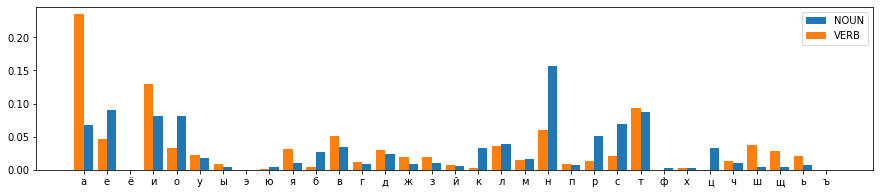

In [33]:
overlay("NOUN","VERB", ClassFreqLST3)

Длина слов по классам 


AVG length by classes


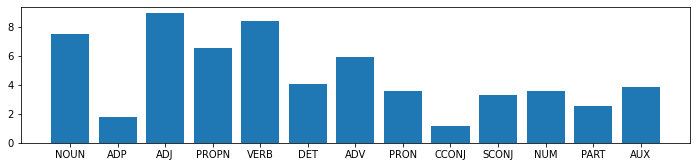

In [34]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClCnt = np.zeros(len(Classes))
CllenAvg = np.zeros(len(Classes))

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                clN = Classes.index(token.pos)
                CllenAvg[clN] += len(token.text)
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    CllenAvg[i] /= ClCnt[i]
             
print("\nAVG length by classes")
        
fig, ax = pylab.subplots()
fig.set_figwidth(12)
fig.set_figheight(2.5) 

ax.bar(Classes,CllenAvg)
pylab.xticks(np.arange(len(Classes)))
pylab.show()

Убедившись, что предлагаемыве признаки действительно отличаются у различных классов, приступим к построению модели

### Обработка данных
Мы не можем передавать на вход модели сами слова, необходимо выделить из них признаки.  
Для этого используем инструмент skl pipeline и skl Transformer.

In [49]:
def LetterPos(letter):
    try:
        return alphabet.index(letter)
    except(ValueError):
        return -1

def CarArr(_word,mult = 1):
    word = copy.deepcopy(_word)
    
    if(len(word) < 3):
        res = np.array([
                        len(word),
                        LetterPos(word[0])*mult,
                        (-1)*mult,
                        LetterPos((word[len(word) - 2]))*mult,
                        LetterPos((word[len(word) - 1]))*mult
                        ], dtype = object)
    else:
        res = np.array([
                        len(word),
                        LetterPos(word[0])*mult,
                        LetterPos((word[len(word) - 3]))*mult,
                        LetterPos((word[len(word) - 2]))*mult,
                        LetterPos(word[len(word) - 1])*mult
                        ], dtype = object)
    return res

class transform(skl.base.TransformerMixin):
    
    def __init__(self,n = 1):
        self.n = n
    
    def fit(self,a,b):
        return self
    
    def transform(self,a):
        res = copy.deepcopy(a)
        for i in range(len(a)):
            res[i] = CarArr(a[i], mult = self.n)
            
        return np.array(res)

In [50]:
transform().transform(["фффыва"])

array([[6, 25, 6, 11, 0]], dtype=object)

### Обучение моделей из skl

При оценки точности используется кросс-валидация случайными разбиениями

In [60]:
class RCV():
    
    def __init__(self,arr_train,arr_test,pipe = None):
        self.train_X = arr_train[0]
        self.train_L = arr_train[1]
        self.test_X = arr_train[0]
        self.test_L = arr_train[1]
        self.pipe = pipe
        
    def apply_model(self,pipe):
        self.pipe = pipe
    
    def validate(self,i = 10,pipe = None,ratio = 0.5,verbal = False):
        if(pipe == None):
            pipe = self.pipe
        if(pipe == None):
            return None
                
        arr = []
        validation_array_X = np.concatenate([self.train_X,self.test_X],axis = 0)
        validation_array_Y = np.concatenate([self.train_L,self.test_L],axis = 0)
        
        for j in range(i):
            cur_validation_array_X, cur_validation_array_Y = skl.utils.shuffle(validation_array_X,validation_array_Y)
            train_X,test_X = np.split(cur_validation_array_X,
                                      [int(len(cur_validation_array_X)*ratio)])
            train_L,test_L = np.split(cur_validation_array_Y,
                                      [int(len(cur_validation_array_Y)*ratio)])
            
            train_X = train_X.tolist()
            train_L = train_L.tolist()
            
            test_X = test_X.tolist()
            test_L = test_L.tolist()
            
            self.pipe.fit(train_X,train_L)
            score = self.pipe.score(test_X,test_L)
            arr.append(score)
            
            if(verbal):
                print("test {} of {} | done".format(j,i))
        
        return np.array(arr,dtype=object)

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [128]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset(AllowedClasses = Classes,unique = False)

In [129]:
rf = RandomForestClassifier()
pipe = Pipeline([('transformer',transform()),('classifier',rf)])
CrossValidataion = RCV([larrDC,larrLB],[tarrDC,tarrLB],pipe = pipe)
arr = CrossValidataion.validate(i = 30,ratio = 0.95,verbal = False)
mean_score = np.mean(arr)

score on train set
0.935076923076923
score on test set
0.8564615384615385
Confusion matrix for train_set


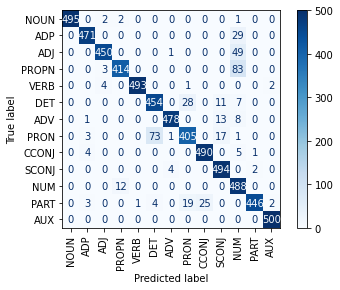

Confusion matrix for test_set


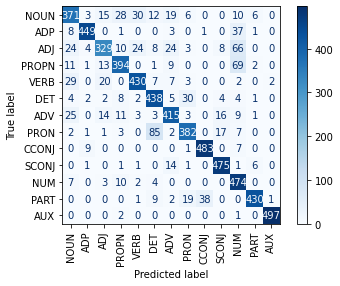

for train set:

              precision    recall  f1-score   support

        NOUN       1.00      0.99      0.99       500
         ADP       0.98      0.94      0.96       500
         ADJ       0.98      0.90      0.94       500
       PROPN       0.97      0.83      0.89       500
        VERB       1.00      0.99      0.99       500
         DET       0.85      0.91      0.88       500
         ADV       0.99      0.96      0.97       500
        PRON       0.89      0.81      0.85       500
       CCONJ       0.95      0.98      0.97       500
       SCONJ       0.92      0.99      0.95       500
         NUM       0.73      0.98      0.83       500
        PART       0.99      0.89      0.94       500
         AUX       0.99      1.00      1.00       500

    accuracy                           0.94      6500
   macro avg       0.94      0.94      0.94      6500
weighted avg       0.94      0.94      0.94      6500

for test set:

              precision    recall  f1-score   su

In [134]:
rf = RandomForestClassifier()
pipe = Pipeline([('transformer',transform()),('classifier',rf)])
pipe.fit(larrDC.tolist(),larrLB.tolist())
print("score on train set")
print(pipe.score(larrDC.tolist(),larrLB.tolist()))
print("score on test set")
print(pipe.score(tarrDC.tolist(),tarrLB.tolist()))

larrPD = np.array([pipe.predict([elm])[0] for elm in larrDC])
tarrPD = np.array([pipe.predict([elm])[0] for elm in tarrDC])

print("Confusion matrix for train_set")
ConfusionMatrixDisplay.from_predictions(larrLB,larrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("Confusion matrix for test_set")
ConfusionMatrixDisplay.from_predictions(tarrLB,tarrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("for train set:\n")
print(classification_report(larrLB,larrPD,target_names = np.array(Classes)))
print("for test set:\n")
print(classification_report(tarrLB,tarrPD,target_names = np.array(Classes)))

### Оценка других классификаторов skl

#### Решающее дерево

score on train set
0.935076923076923
score on test set
0.8313846153846154
Confusion matrix for train_set


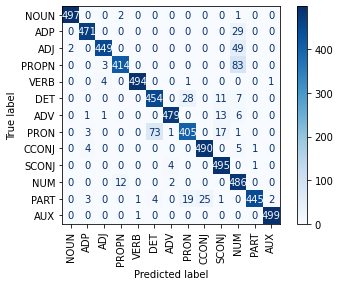

Confusion matrix for test_set


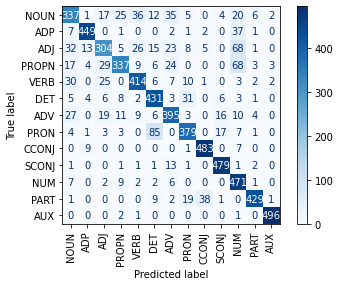

for train set:

              precision    recall  f1-score   support

        NOUN       1.00      0.99      0.99       500
         ADP       0.98      0.94      0.96       500
         ADJ       0.98      0.90      0.94       500
       PROPN       0.97      0.83      0.89       500
        VERB       1.00      0.99      0.99       500
         DET       0.85      0.91      0.88       500
         ADV       0.99      0.96      0.97       500
        PRON       0.89      0.81      0.85       500
       CCONJ       0.95      0.98      0.97       500
       SCONJ       0.92      0.99      0.95       500
         NUM       0.73      0.97      0.83       500
        PART       1.00      0.89      0.94       500
         AUX       0.99      1.00      1.00       500

    accuracy                           0.94      6500
   macro avg       0.94      0.94      0.94      6500
weighted avg       0.94      0.94      0.94      6500

for test set:

              precision    recall  f1-score   su

In [136]:
dt = DecisionTreeClassifier()
pipe = Pipeline([('transformer',transform()),('classifier',dt)])
pipe.fit(larrDC.tolist(),larrLB.tolist())
print("score on train set")
print(pipe.score(larrDC.tolist(),larrLB.tolist()))
print("score on test set")
print(pipe.score(tarrDC.tolist(),tarrLB.tolist()))

larrPD = np.array([pipe.predict([elm])[0] for elm in larrDC])
tarrPD = np.array([pipe.predict([elm])[0] for elm in tarrDC])

print("Confusion matrix for train_set")
ConfusionMatrixDisplay.from_predictions(larrLB,larrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("Confusion matrix for test_set")
ConfusionMatrixDisplay.from_predictions(tarrLB,tarrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("for train set:\n")
print(classification_report(larrLB,larrPD,target_names = np.array(Classes)))
print("for test set:\n")
print(classification_report(tarrLB,tarrPD,target_names = np.array(Classes)))

#### Логистическая регрессия

C:\Users\max\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score on train set
0.4586153846153846
score on test set
0.4503076923076923
Confusion matrix for train_set


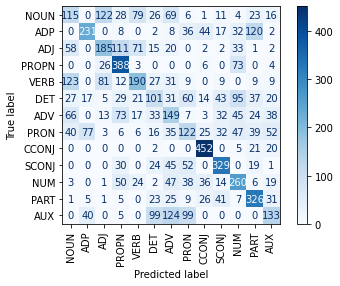

Confusion matrix for test_set


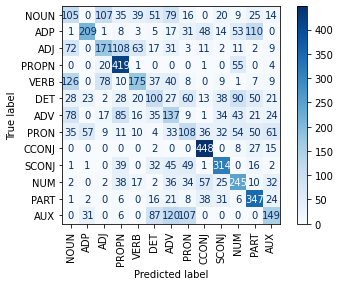

for train set:

              precision    recall  f1-score   support

        NOUN       0.27      0.23      0.25       500
         ADP       0.62      0.46      0.53       500
         ADJ       0.42      0.37      0.39       500
       PROPN       0.52      0.78      0.62       500
        VERB       0.46      0.38      0.42       500
         DET       0.27      0.20      0.23       500
         ADV       0.26      0.30      0.27       500
        PRON       0.28      0.24      0.26       500
       CCONJ       0.74      0.90      0.82       500
       SCONJ       0.62      0.66      0.64       500
         NUM       0.43      0.52      0.47       500
        PART       0.52      0.65      0.58       500
         AUX       0.38      0.27      0.31       500

    accuracy                           0.46      6500
   macro avg       0.45      0.46      0.45      6500
weighted avg       0.45      0.46      0.45      6500

for test set:

              precision    recall  f1-score   su

In [138]:
lr = LogisticRegression()
pipe = Pipeline([('transformer',transform()),('classifier',lr)])
pipe.fit(larrDC.tolist(),larrLB.tolist())
print("score on train set")
print(pipe.score(larrDC.tolist(),larrLB.tolist()))
print("score on test set")
print(pipe.score(tarrDC.tolist(),tarrLB.tolist()))

larrPD = np.array([pipe.predict([elm])[0] for elm in larrDC])
tarrPD = np.array([pipe.predict([elm])[0] for elm in tarrDC])

print("Confusion matrix for train_set")
ConfusionMatrixDisplay.from_predictions(larrLB,larrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("Confusion matrix for test_set")
ConfusionMatrixDisplay.from_predictions(tarrLB,tarrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("for train set:\n")
print(classification_report(larrLB,larrPD,target_names = np.array(Classes)))
print("for test set:\n")
print(classification_report(tarrLB,tarrPD,target_names = np.array(Classes)))

#### Наивный байесовский классификатор

score on train set
0.48415384615384616
score on test set
0.47
Confusion matrix for train_set


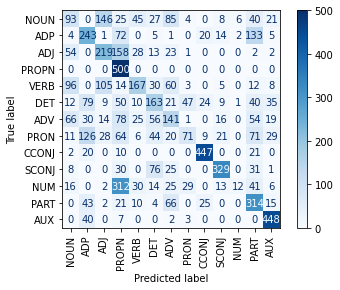

Confusion matrix for test_set


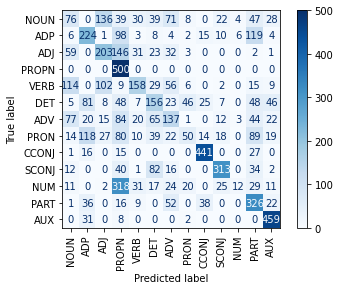

for train set:

              precision    recall  f1-score   support

        NOUN       0.26      0.19      0.22       500
         ADP       0.42      0.49      0.45       500
         ADJ       0.42      0.44      0.43       500
       PROPN       0.37      1.00      0.54       500
        VERB       0.52      0.33      0.41       500
         DET       0.38      0.33      0.35       500
         ADV       0.30      0.28      0.29       500
        PRON       0.45      0.14      0.22       500
       CCONJ       0.85      0.89      0.87       500
       SCONJ       0.79      0.66      0.72       500
         NUM       0.57      0.02      0.05       500
        PART       0.41      0.63      0.50       500
         AUX       0.76      0.90      0.82       500

    accuracy                           0.48      6500
   macro avg       0.50      0.48      0.45      6500
weighted avg       0.50      0.48      0.45      6500

for test set:

              precision    recall  f1-score   su

In [139]:
nb = GaussianNB()
pipe = Pipeline([('transformer',transform()),('classifier',nb)])
pipe.fit(larrDC.tolist(),larrLB.tolist())
print("score on train set")
print(pipe.score(larrDC.tolist(),larrLB.tolist()))
print("score on test set")
print(pipe.score(tarrDC.tolist(),tarrLB.tolist()))

larrPD = np.array([pipe.predict([elm])[0] for elm in larrDC])
tarrPD = np.array([pipe.predict([elm])[0] for elm in tarrDC])

print("Confusion matrix for train_set")
ConfusionMatrixDisplay.from_predictions(larrLB,larrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("Confusion matrix for test_set")
ConfusionMatrixDisplay.from_predictions(tarrLB,tarrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("for train set:\n")
print(classification_report(larrLB,larrPD,target_names = np.array(Classes)))
print("for test set:\n")
print(classification_report(tarrLB,tarrPD,target_names = np.array(Classes)))

#### KNN

score on train set
0.8318461538461538
score on test set
0.7698461538461538
Confusion matrix for train_set


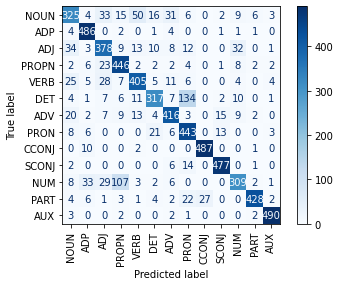

Confusion matrix for test_set


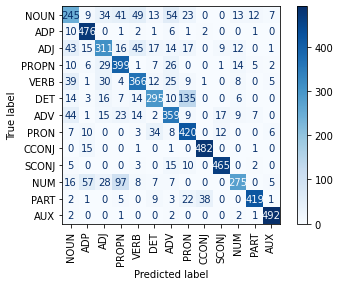

for train set:

              precision    recall  f1-score   support

        NOUN       0.74      0.65      0.69       500
         ADP       0.86      0.97      0.92       500
         ADJ       0.75      0.76      0.75       500
       PROPN       0.74      0.89      0.81       500
        VERB       0.81      0.81      0.81       500
         DET       0.83      0.63      0.72       500
         ADV       0.83      0.83      0.83       500
        PRON       0.69      0.89      0.77       500
       CCONJ       0.95      0.97      0.96       500
       SCONJ       0.93      0.95      0.94       500
         NUM       0.81      0.62      0.70       500
        PART       0.96      0.86      0.91       500
         AUX       0.97      0.98      0.97       500

    accuracy                           0.83      6500
   macro avg       0.84      0.83      0.83      6500
weighted avg       0.84      0.83      0.83      6500

for test set:

              precision    recall  f1-score   su

In [140]:
knn = KNeighborsClassifier()
pipe = Pipeline([('transformer',transform()),('classifier',knn)])
pipe.fit(larrDC.tolist(),larrLB.tolist())
print("score on train set")
print(pipe.score(larrDC.tolist(),larrLB.tolist()))
print("score on test set")
print(pipe.score(tarrDC.tolist(),tarrLB.tolist()))

larrPD = np.array([pipe.predict([elm])[0] for elm in larrDC])
tarrPD = np.array([pipe.predict([elm])[0] for elm in tarrDC])

print("Confusion matrix for train_set")
ConfusionMatrixDisplay.from_predictions(larrLB,larrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("Confusion matrix for test_set")
ConfusionMatrixDisplay.from_predictions(tarrLB,tarrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("for train set:\n")
print(classification_report(larrLB,larrPD,target_names = np.array(Classes)))
print("for test set:\n")
print(classification_report(tarrLB,tarrPD,target_names = np.array(Classes)))

Ни один из прочих алгоритмов машинного обучения не показал столь же высокой точности на стандартных параметрах, что случайный лес.

score on train set
0.8810769230769231
score on test set
0.7566153846153846
Confusion matrix for train_set


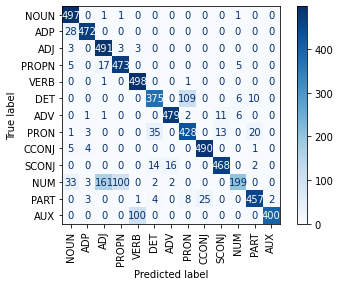

Confusion matrix for test_set


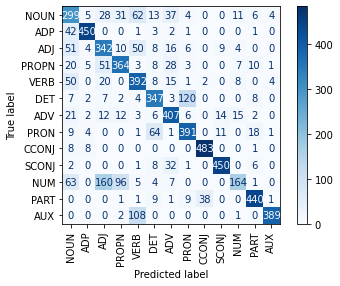

for train set:

              precision    recall  f1-score   support

        NOUN       0.87      0.99      0.93       500
         ADP       0.97      0.94      0.96       500
         ADJ       0.73      0.98      0.84       500
       PROPN       0.82      0.95      0.88       500
        VERB       0.83      1.00      0.90       500
         DET       0.87      0.75      0.81       500
         ADV       0.96      0.96      0.96       500
        PRON       0.78      0.86      0.82       500
       CCONJ       0.95      0.98      0.97       500
       SCONJ       0.95      0.94      0.94       500
         NUM       0.92      0.40      0.56       500
        PART       0.93      0.91      0.92       500
         AUX       1.00      0.80      0.89       500

    accuracy                           0.88      6500
   macro avg       0.89      0.88      0.87      6500
weighted avg       0.89      0.88      0.87      6500

for test set:

              precision    recall  f1-score   su

In [142]:
knn = KNeighborsClassifier(n_neighbors = 1)
pipe = Pipeline([('transformer',transform()),('classifier',knn)])
pipe.fit(larrDC.tolist(),larrLB.tolist())
print("score on train set")
print(pipe.score(larrDC.tolist(),larrLB.tolist()))
print("score on test set")
print(pipe.score(tarrDC.tolist(),tarrLB.tolist()))

larrPD = np.array([pipe.predict([elm])[0] for elm in larrDC])
tarrPD = np.array([pipe.predict([elm])[0] for elm in tarrDC])

print("Confusion matrix for train_set")
ConfusionMatrixDisplay.from_predictions(larrLB,larrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("Confusion matrix for test_set")
ConfusionMatrixDisplay.from_predictions(tarrLB,tarrPD,display_labels = np.array(Classes),cmap = 'Blues',
                                        xticks_rotation = 'vertical')
pylab.show()

print("for train set:\n")
print(classification_report(larrLB,larrPD,target_names = np.array(Classes)))
print("for test set:\n")
print(classification_report(tarrLB,tarrPD,target_names = np.array(Classes)))

In [108]:
np.unique(larrLB)

array([0, 1, 2, 3, 4, 5])

In [83]:
Classes

['NOUN',
 'ADP',
 'ADJ',
 'PROPN',
 'VERB',
 'DET',
 'ADV',
 'PRON',
 'CCONJ',
 'SCONJ',
 'NUM',
 'PART',
 'AUX']

In [79]:
larrLB

array([0, 1, 0, ..., 4, 4, 4])

In [78]:
larrPD

[array([0]),
 array([1]),
 array([0]),
 array([2]),
 array([2]),
 array([3]),
 array([0]),
 array([2]),
 array([3]),
 array([4]),
 array([1]),
 array([0]),
 array([0]),
 array([3]),
 array([5]),
 array([2]),
 array([0]),
 array([2]),
 array([4]),
 array([1]),
 array([0]),
 array([3]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([4]),
 array([2]),
 array([3]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([3]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([3]),
 array([4]),
 array([5]),
 array([0]),
 array([2]),
 array([5]),
 array([0]),
 array([3]),
 array([5]),
 array([0]),
 array([0]),
 array([5]),
 array([0]),
 array([5]),
 array([0]),
 array([4]),
 array([1]),
 array([1]),
 array([0]),
 array([3]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([3]),
 array([0]),
 array([2]),
 array([2]),
 array([1]),